In [17]:
import sys
from pathlib import Path
project_path = Path("/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/")
sys.path.append(str(project_path))
from utils.PDFSerlalizer import DocumentHandler
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import joblib
import argparse
import numpy as np
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [18]:
pdf_file = "/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/cs_ai_2024_pdfs/test2.pdf"
image_dir = "/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/demos/kostas_ignore/output/"
pretrained_model = "/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/kostas_ignore/svm_vgg_model.pkl"

doc = DocumentHandler()
doc.extract_images(
    pdf_file,
    image_dir,
    verbose=True,
    export_pages=False,
    export_figures=True,
    export_tables=True,
    do_ocr=True,
    do_table_structure=True,
    add_caption=True,
    filter_irrelevant=True,
    generate_metadata=False,
    generate_annotated_pdf=False,
    generate_descriptions=False,
    generate_table_markdown=False,
    relevant_passages=2,
    prompt_passages=False
)

labelNames = ['3D objects', 'Algorithm', 'Area chart', 'Bar plots', 'Block diagram', 'Box plot', 'Bubble Chart',
              'Confusion matrix', 'Contour plot', 'Flow chart', 'Geographic map', 'Graph plots', 'Heat map', 
              'Histogram', 'Mask', 'Medical images', 'Natural images', 'Pareto charts', 'Pie chart', 'Polar plot', 
              'Radar chart', 'Scatter plot', 'Sketches', 'Surface plot', 'Tables', 'Tree Diagram', 'Vector plot', 
              'Venn Diagram']

Processing PDF: /data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/cs_ai_2024_pdfs/test2.pdf...
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Skipping irrelevant image
Process completed in 13.22 seconds


In [19]:
vgg_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg_model.eval()  # Set to evaluation mode

# Remove the last fully connected layer to get FC-CNN features
fc_cnn_model = torch.nn.Sequential(*list(vgg_model.children())[:-1])

In [20]:
# Function to extract FC-CNN features
def extract_fc_cnn_features(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Extract features
    with torch.no_grad():
        features = fc_cnn_model(image_tensor)
    
    return features.squeeze().numpy()

# Function to extract FV-CNN features (simplified version)
def extract_fv_cnn_features(image_path):
    # For simplicity, we use the same VGG model but extract features from the last convolutional layer
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0)

    # Extract features from the last convolutional layer
    with torch.no_grad():
        conv_features = vgg_model.features(image_tensor)
    
    # Flatten and return the features
    return conv_features.squeeze().numpy().flatten()

# Combine features to match training setup
def extract_features(image_path):
    fc_features = extract_fc_cnn_features(image_path).flatten()
    fv_features = extract_fv_cnn_features(image_path).flatten()
    return np.concatenate((fc_features, fv_features))

svm_model = joblib.load(pretrained_model)

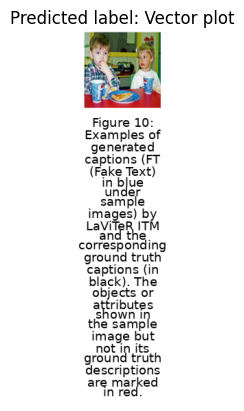

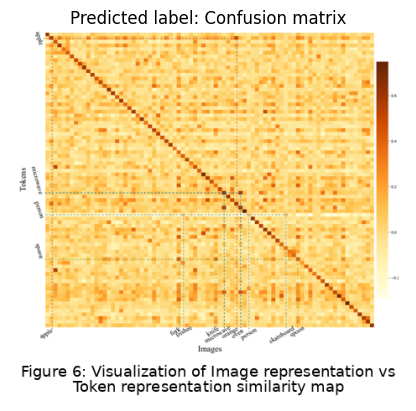

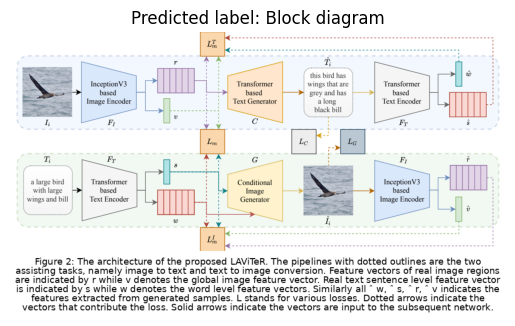

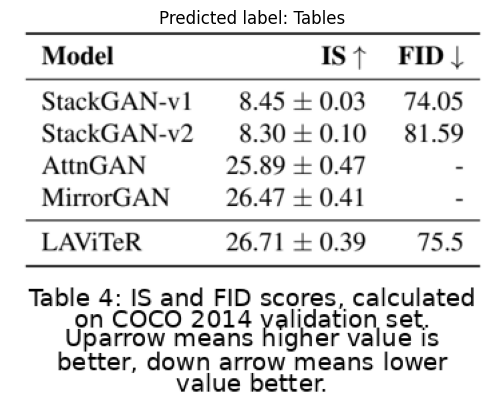

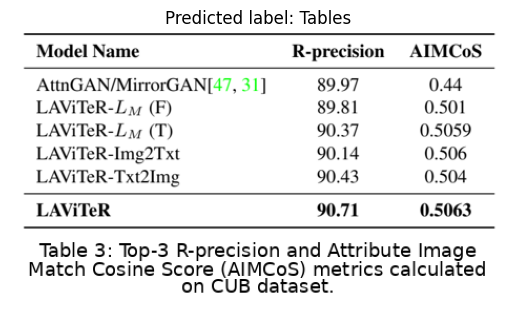

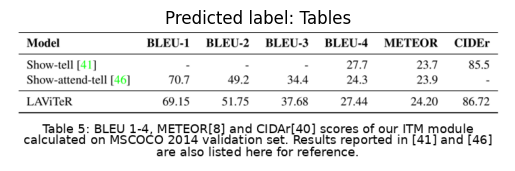

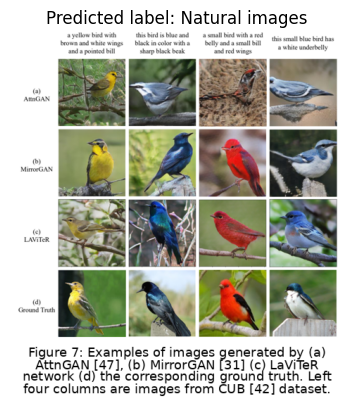

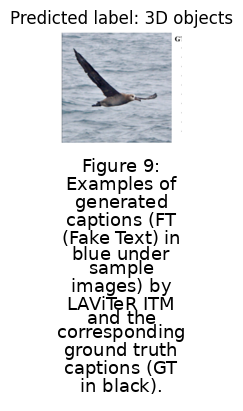

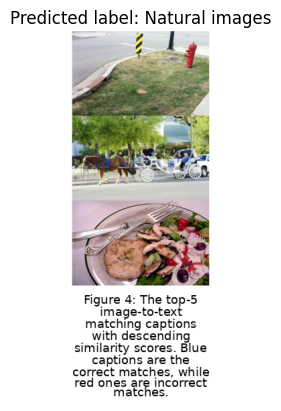

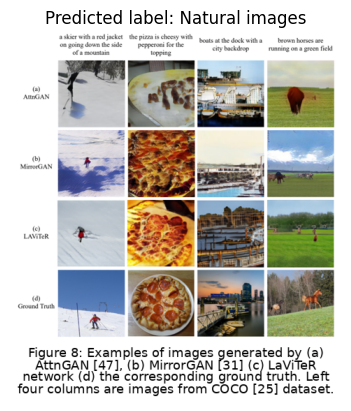

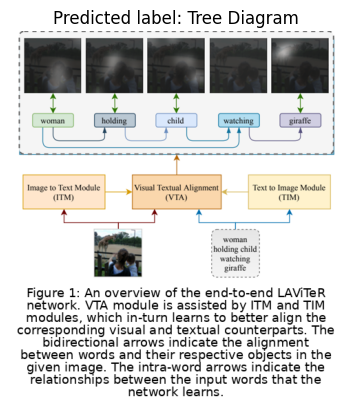

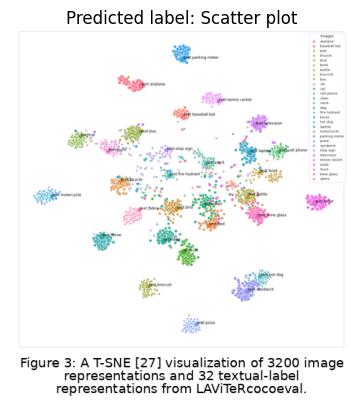

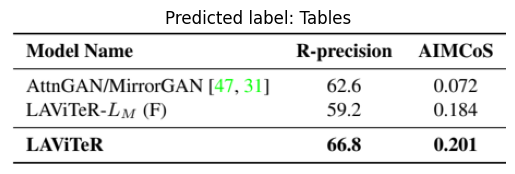

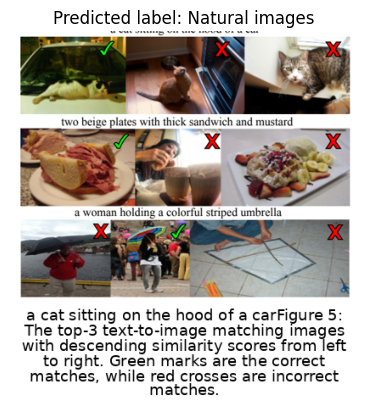

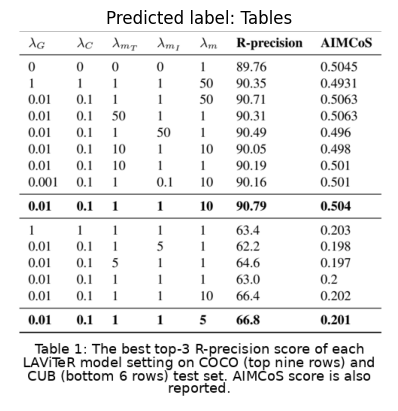

In [21]:
for img_path in Path(image_dir).rglob('*.png'):
    features = extract_features(img_path)
    label = svm_model.predict([features])[0]
    
    # Plot the image and the predicted label
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted label: {labelNames[label]}")
    plt.show()  # This is necessary to display the plot